In [1]:
import pandas as pd
import os
import ast
data_path = '/home/evangelos/src/disaster-impact/data_mid/data_standardised/'


standardised_dfs = {
    "glide": pd.read_csv(os.path.join(data_path, 'glide_standardised.csv')),
    "gdacs": pd.read_csv(os.path.join(data_path, 'gdacs_standardised.csv')),
    "disaster_charter": pd.read_csv(os.path.join(data_path, 'disaster_charter_standardised.csv')),
    "emdat": pd.read_csv(os.path.join(data_path, 'emdat_standardised.csv')),
    "idmc": pd.read_csv(os.path.join(data_path, 'idmc_standardised.csv')),
    "cerf": pd.read_csv(os.path.join(data_path, 'cerf_standardised.csv')),
    "ifrc": pd.read_csv(os.path.join(data_path, 'ifrc_standardised.csv'))
}

# for name, df in standardised_dfs.items():
#     print(f"Dataset: {name}, Shape: {df.shape}")
#     if not df.empty:
#         display(df.iloc[0])
#     else:
#         print("The DataFrame is empty.")


def prefix_event_ids(value, prefix):
    if pd.isna(value):
        return None
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        try:
            parsed = ast.literal_eval(value)
            if not isinstance(parsed, list):
                parsed = [parsed]
            return [f"{prefix}_{item}" for item in parsed]
        except:
            return f"{prefix}_{value}"
    else:
        if isinstance(value, list):
            return [f"{prefix}_{item}" for item in value]
        else:
            return f"{prefix}_{value}"

for name, df in standardised_dfs.items():
    if "Event_ID" in df.columns:
        df["Event_ID"] = df["Event_ID"].apply(lambda x: prefix_event_ids(x, name))


In [2]:
all_data = pd.concat(standardised_dfs.values(), ignore_index=True)

/tmp/ipykernel_178862/201937051.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat(standardised_dfs.values(), ignore_index=True)


Analysis 1

In [36]:
import hashlib

group_key = ['Event_Type', 'Country', 'Date']

def consolidate_group(group):
    consolidated_row = {}
    event_ids = sorted(set(group['Event_ID'].dropna().astype(str).tolist()))
    consolidated_row["Event_ID"] = event_ids

    unique_str = "|".join(event_ids)
    disaster_impact_id = "DI_" + hashlib.md5(unique_str.encode("utf-8")).hexdigest()
    consolidated_row["Disaster_Impact_ID"] = disaster_impact_id

    for column in group.columns:
        if column in group_key or column == "Event_ID" or column == "Disaster_Impact_ID":
            if column == "Disaster_Impact_ID":
                continue
            consolidated_row[column] = sorted(set(group[column].dropna().astype(str).tolist()))
        else:
            values = group[column].dropna().tolist()
            if values:
                if all(isinstance(val, list) for val in values):
                    flat_values = [item for sublist in values for item in sublist]
                    consolidated_row[column] = sorted(set(map(str, flat_values)))
                else:
                    consolidated_row[column] = sorted(set(map(str, values)))
            else:
                consolidated_row[column] = None

    return consolidated_row



Analysis 1

In [37]:
unified_rows = []
for _, group in all_data.groupby(group_key):
    unified_rows.append(consolidate_group(group))

unified_df = pd.DataFrame(unified_rows)

cols = ['Disaster_Impact_ID', 'Event_ID'] + [c for c in unified_df.columns if c not in ('Disaster_Impact_ID','Event_ID')]
unified_df = unified_df[cols]

print(f"Unified DataFrame shape: {unified_df.shape}")
display(unified_df.head())

Unified DataFrame shape: (66886, 29)


,Disaster_Impact_ID,Event_ID,Source_Event_IDs,Event_Name,Event_Type,Country,Country_Code,Location,Latitude,Longitude,...,Financial_Loss,Alert_Level,Source,Comments,External_Links,AID_Contribution,Admin_Units,External_IDs,Approval_Date,Disbursement_Date
0,DI_38b6c39da0f00ce35fb11b327947c987,[glide_e0c9f247a7808cc69f6652e56d051d99],[['AC-2000-000005-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Fuging']],[[19.0785907]],[[-98.2598043]],...,None,[[]],[['[]']],"[[""['(Road)']""]]",[[]],None,[[]],[[]],None,None
1,DI_55a537b19ff1fb6709ace74673fe1687,[glide_b58780e7c552092bf2392bc2d1b0b8be],[['AC-2000-000006-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Xiangtan (Hunan Province)']],[[19.0785907]],[[-98.2598043]],...,None,[[]],[['[]']],"[[""['{Hotel} (Misc:Fire)']""]]",[[]],None,[[]],[[]],None,None
2,DI_3349612a14a4481e3b7f3c16dec96300,[glide_649016f3fb106db945bfcc081e4c3bab],[['AC-2000-000034-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Jiangsu Province']],[[32.061707]],[[118.763232]],...,None,[[]],[['[]']],"[[""['{Coal Mine} (Ind:Collapse)']""]]",[[]],None,[[]],[[]],None,None
3,DI_f95438b2942c1a1ded4297e3f5dcddbb,[glide_8f1649c0fc7a534bf0d99a381cd57524],[['AC-2000-000093-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Guigang (Guangxi Province)']],[[23.111531]],[[109.598927]],...,None,[[]],[['[]']],"[[""['(Misc:Fire)']""]]",[[]],None,[[]],[[]],None,None
4,DI_2fc9b60a9b7cc8ce4e7fc276d7b3eb5a,[glide_cf14cab0de23931d096296308952c1d1],[['AC-2000-000026-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Shunde']],[[19.0785907]],[[-98.2598043]],...,None,[[]],[['[]']],"[[""['(Road)']""]]",[[]],None,[[]],[[]],None,None


Analysis 2

In [3]:
import pandas as pd
import hashlib

group_key = ['Event_Type', 'Country']

def consolidate_group(group):
    consolidated_row = {}
    event_ids = sorted(set(group['Event_ID'].dropna().astype(str).tolist()))
    consolidated_row["Event_ID"] = event_ids
    unique_str = "|".join(event_ids)
    disaster_impact_id = "DI_" + hashlib.md5(unique_str.encode("utf-8")).hexdigest()
    consolidated_row["Disaster_Impact_ID"] = disaster_impact_id
    for column in group.columns:
        if column in group_key or column == "Event_ID" or column == "Disaster_Impact_ID":
            if column == "Disaster_Impact_ID":
                continue
            consolidated_row[column] = sorted(set(group[column].dropna().astype(str).tolist()))
        else:
            values = group[column].dropna().tolist()
            if values:
                if all(isinstance(val, list) for val in values):
                    flat_values = [item for sublist in values for item in sublist]
                    consolidated_row[column] = sorted(set(map(str, flat_values)))
                else:
                    consolidated_row[column] = sorted(set(map(str, values)))
            else:
                consolidated_row[column] = None
    return consolidated_row

all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Date_Group'] = all_data['Date'].apply(lambda x: (x - pd.Timedelta(days=7), x + pd.Timedelta(days=7)))

def group_by_date_range(data, date_col):
    rows = []
    used_indices = set()
    for idx, row in data.iterrows():
        if idx in used_indices:
            continue
        matching_rows = data[
            (data[date_col] >= row['Date_Group'][0]) &
            (data[date_col] <= row['Date_Group'][1]) &
            (data['Event_Type'] == row['Event_Type']) &
            (data['Country'] == row['Country'])
        ]
        used_indices.update(matching_rows.index)
        rows.append(consolidate_group(matching_rows))
    return rows


In [4]:
unified_rows = group_by_date_range(all_data, 'Date')
unified_df = pd.DataFrame(unified_rows)
cols = ['Disaster_Impact_ID', 'Event_ID'] + [c for c in unified_df.columns if c not in ('Disaster_Impact_ID','Event_ID')]
unified_df = unified_df[cols]
print(unified_df.shape)
unified_df.head()


(45524, 30)


,Disaster_Impact_ID,Event_ID,Source_Event_IDs,Event_Name,Event_Type,Country,Country_Code,Location,Latitude,Longitude,...,Alert_Level,Source,Comments,External_Links,AID_Contribution,Admin_Units,External_IDs,Approval_Date,Disbursement_Date,Date_Group
0,DI_38b6c39da0f00ce35fb11b327947c987,[glide_e0c9f247a7808cc69f6652e56d051d99],[['AC-2000-000005-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Fuging']],[[19.0785907]],[[-98.2598043]],...,[[]],[['[]']],"[[""['(Road)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('1999-12-25 00:00:00'), Timestamp(..."
1,DI_5b0f0be81b242db8a15db2cde53a890c,"[glide_649016f3fb106db945bfcc081e4c3bab, glide...","[['AC-2000-000006-CHN'], ['AC-2000-000034-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Jiangsu Province'], ['Xiangtan (Hunan Provi...","[[19.0785907], [32.061707]]","[[-98.2598043], [118.763232]]",...,[[]],[['[]']],"[[""['{Coal Mine} (Ind:Collapse)']""], [""['{Hote...",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-01-02 00:00:00'), Timestamp(..."
2,DI_f0cf3c14f8ba2bf8e063e1e86488d0fc,"[glide_8f1649c0fc7a534bf0d99a381cd57524, glide...","[['AC-2000-000026-CHN'], ['AC-2000-000093-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Guigang (Guangxi Province)'], ['Shunde']]","[[19.0785907], [23.111531]]","[[-98.2598043], [109.598927]]",...,[[]],[['[]']],"[[""['(Misc:Fire)']""], [""['(Road)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-01-20 00:00:00'), Timestamp(..."
3,DI_6498c5e34d7c9dfe15cd17006390158e,[glide_ce1edc8b9e6333f7cddb748384a18ec3],[['AC-2000-000102-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Jilin Province']],[[43.896082]],[[125.326065]],...,[[]],[['[]']],"[[""['{Coal mine} (Ind:Explosion)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-02-02 00:00:00'), Timestamp(..."
4,DI_71f32a116fd5821258b52d4c3dde64e2,[glide_43f91c8e196e296cf7abf1d143573164],[['AC-2000-000114-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Dacheng County (Hebei Province)']],[[19.0785907]],[[-98.2598043]],...,[[]],[['[]']],"[[""['(Misc:Explosion)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-02-10 00:00:00'), Timestamp(..."


In [5]:
os.makedirs('/home/evangelos/src/disaster-impact/data_out/data_unified/', exist_ok=True)

unified_df.to_csv('/home/evangelos/src/disaster-impact/data_out/data_unified/unified_data.csv', index=False)

In [8]:
analysis_df = unified_df.copy()
display(unified_df.iloc[28412])
display(analysis_df.head())


Disaster_Impact_ID                   DI_b3d744767c987115564e9fc5495acb2e
Event_ID                        [emdat_5d188e6572ec51e2dc4b0060fb2ef3ba]
Source_Event_IDs                                     [['2011-0347-PAK']]
Event_Name                                                      [['[]']]
Event_Type                                                   [['Flood']]
Country                                                   [['Pakistan']]
Country_Code                                               [["['PAK']"]]
Location               [['Badin, Dadu, Ghotki, Hyderabad, Jacobabad, ...
Latitude                                                      [[25.012]]
Longitude                                                      [[69.07]]
Date                                               [2011-08-12 00:00:00]
Year                                                              [2011]
Month                                                              [8.0]
Day                                                

,Disaster_Impact_ID,Event_ID,Source_Event_IDs,Event_Name,Event_Type,Country,Country_Code,Location,Latitude,Longitude,...,Alert_Level,Source,Comments,External_Links,AID_Contribution,Admin_Units,External_IDs,Approval_Date,Disbursement_Date,Date_Group
0,DI_38b6c39da0f00ce35fb11b327947c987,[glide_e0c9f247a7808cc69f6652e56d051d99],[['AC-2000-000005-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Fuging']],[[19.0785907]],[[-98.2598043]],...,[[]],[['[]']],"[[""['(Road)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('1999-12-25 00:00:00'), Timestamp(..."
1,DI_5b0f0be81b242db8a15db2cde53a890c,"[glide_649016f3fb106db945bfcc081e4c3bab, glide...","[['AC-2000-000006-CHN'], ['AC-2000-000034-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Jiangsu Province'], ['Xiangtan (Hunan Provi...","[[19.0785907], [32.061707]]","[[-98.2598043], [118.763232]]",...,[[]],[['[]']],"[[""['{Coal Mine} (Ind:Collapse)']""], [""['{Hote...",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-01-02 00:00:00'), Timestamp(..."
2,DI_f0cf3c14f8ba2bf8e063e1e86488d0fc,"[glide_8f1649c0fc7a534bf0d99a381cd57524, glide...","[['AC-2000-000026-CHN'], ['AC-2000-000093-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Guigang (Guangxi Province)'], ['Shunde']]","[[19.0785907], [23.111531]]","[[-98.2598043], [109.598927]]",...,[[]],[['[]']],"[[""['(Misc:Fire)']""], [""['(Road)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-01-20 00:00:00'), Timestamp(..."
3,DI_6498c5e34d7c9dfe15cd17006390158e,[glide_ce1edc8b9e6333f7cddb748384a18ec3],[['AC-2000-000102-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Jilin Province']],[[43.896082]],[[125.326065]],...,[[]],[['[]']],"[[""['{Coal mine} (Ind:Explosion)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-02-02 00:00:00'), Timestamp(..."
4,DI_71f32a116fd5821258b52d4c3dde64e2,[glide_43f91c8e196e296cf7abf1d143573164],[['AC-2000-000114-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Dacheng County (Hebei Province)']],[[19.0785907]],[[-98.2598043]],...,[[]],[['[]']],"[[""['(Misc:Explosion)']""]]",[[]],None,[[]],[[]],None,None,"[(Timestamp('2000-02-10 00:00:00'), Timestamp(..."


In [9]:
def has_prefix(id_list, prefix):
    if isinstance(id_list, list):
        return any(str(item).startswith(prefix + "_") for item in id_list)
    return False

analysis_df['gdacs'] = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'gdacs'))
analysis_df['glide'] = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'glide'))
analysis_df['cerf']  = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'cerf'))
analysis_df['charter'] = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'disaster_charter'))
analysis_df['emdat'] = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'emdat'))
analysis_df['idmc']  = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'idmc'))
analysis_df['dref']  = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'dref'))
analysis_df['ifrc']  = analysis_df['Event_ID'].apply(lambda lst: has_prefix(lst, 'ifrc'))

analysis_df['nb_sources'] = analysis_df[[
    'gdacs','glide','cerf','charter','emdat','idmc','dref','ifrc'
]].sum(axis=1)

display(analysis_df.head(10))


,Disaster_Impact_ID,Event_ID,Source_Event_IDs,Event_Name,Event_Type,Country,Country_Code,Location,Latitude,Longitude,...,Date_Group,gdacs,glide,cerf,charter,emdat,idmc,dref,ifrc,nb_sources
0,DI_38b6c39da0f00ce35fb11b327947c987,[glide_e0c9f247a7808cc69f6652e56d051d99],[['AC-2000-000005-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Fuging']],[[19.0785907]],[[-98.2598043]],...,"[(Timestamp('1999-12-25 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
1,DI_5b0f0be81b242db8a15db2cde53a890c,"[glide_649016f3fb106db945bfcc081e4c3bab, glide...","[['AC-2000-000006-CHN'], ['AC-2000-000034-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Jiangsu Province'], ['Xiangtan (Hunan Provi...","[[19.0785907], [32.061707]]","[[-98.2598043], [118.763232]]",...,"[(Timestamp('2000-01-02 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
2,DI_f0cf3c14f8ba2bf8e063e1e86488d0fc,"[glide_8f1649c0fc7a534bf0d99a381cd57524, glide...","[['AC-2000-000026-CHN'], ['AC-2000-000093-CHN']]","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[['Guigang (Guangxi Province)'], ['Shunde']]","[[19.0785907], [23.111531]]","[[-98.2598043], [109.598927]]",...,"[(Timestamp('2000-01-20 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
3,DI_6498c5e34d7c9dfe15cd17006390158e,[glide_ce1edc8b9e6333f7cddb748384a18ec3],[['AC-2000-000102-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Jilin Province']],[[43.896082]],[[125.326065]],...,"[(Timestamp('2000-02-02 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
4,DI_71f32a116fd5821258b52d4c3dde64e2,[glide_43f91c8e196e296cf7abf1d143573164],[['AC-2000-000114-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Dacheng County (Hebei Province)']],[[19.0785907]],[[-98.2598043]],...,"[(Timestamp('2000-02-10 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
5,DI_39f897a8e8fe401272f2b151ecea6836,[glide_128f5892698e7533df4fb30445c9cdd8],[['AC-2000-000086-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Guangxi Province']],[[22.815478]],[[108.327546]],...,"[(Timestamp('2000-02-19 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
6,DI_79024f6e980a24e555401271019d9e1a,[glide_206d13add805d874b1f685819ee70b7d],[['AC-2000-000169-CHN']],"[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]",[['Pingxiang (Jiangxi province)']],[[19.0785907]],[[-98.2598043]],...,"[(Timestamp('2000-03-04 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
7,DI_ea5cdcbec95c5d249ebc860e6807c3b0,"[glide_14b7e5276165e87de1226bddcc2b8d41, glide...","[[""['AC-2000-000161-CHN']"", ""['AC-2000-000125-...","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[[""['Jiaozou (Henan province)']"", ""['Near Shuo...","[['[19.0785907]', '[19.0785907]'], [19.0785907]]","[['[-98.2598043]', '[-98.2598043]'], [-98.2598...",...,"[(Timestamp('2000-03-21 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
8,DI_5dd4ce2dd6e674223b7a7fd650ccb1c5,"[glide_00b530702b6a4a1c9e927e72133aa4c7, glide...","[['AC-2000-000171-CHN'], ['AC-2000-000189-CHN'...","[[""['Tech. Disaster']""]]",[['AC']],"[[""China, People's Republic""]]","[[""['CHN']""]]","[[""Shandong's Dezhou""], ['Chenzhou (Hunan Prov...","[[19.0785907], [25.77051]]","[[-98.2598043], [113.014718]]",...,"[(Timestamp('2000-03-24 00:00:00'), Timestamp(...",False,True,False,False,False,False,False,False,1
9,DI_cc9d54a9520a9a6f8e370bcf2f6f3a2d,"[glide_00b530702b6a4a1c9e927e72133aa4c7, glide...","[['AC-2000-000199-CHN'], ['AC-2000-000210-CHN'...","[[""['Tech. Disaster']""]]",[['AC']],"

In [10]:
source_list = ['gdacs','glide','cerf','charter','emdat','idmc','dref','ifrc']
no_match_list = []
match_list = []

for source in source_list:
    single_source_mask = (analysis_df[source]) & (analysis_df['nb_sources'] == 1)
    multi_source_mask  = (analysis_df[source]) & (analysis_df['nb_sources'] > 1)

    x = single_source_mask.sum()  # number of rows that belong ONLY to this source
    y = multi_source_mask.sum()   # number of rows that belong to this and at least 1 more source

    no_match_list.append(x)
    match_list.append(y)

plot_df = pd.DataFrame()
plot_df['source'] = source_list
plot_df['no_match'] = no_match_list
plot_df['match'] = match_list
plot_df['total'] = plot_df['no_match'] + plot_df['match']
plot_df['score'] = plot_df['match'] / plot_df['total'].replace(0, None)

display(plot_df)


,source,no_match,match,total,score
0,gdacs,16099,1004,17103,0.058703
1,glide,6033,1004,7037,0.142674
2,cerf,0,0,0,NaN
3,charter,322,54,376,0.143617
4,emdat,9210,368,9578,0.038421
5,idmc,8833,2,8835,0.000226
6,dref,0,0,0,NaN
7,ifrc,3655,345,4000,0.08625


analysis 1

Text(0.5, 1.0, 'Number of events per source')

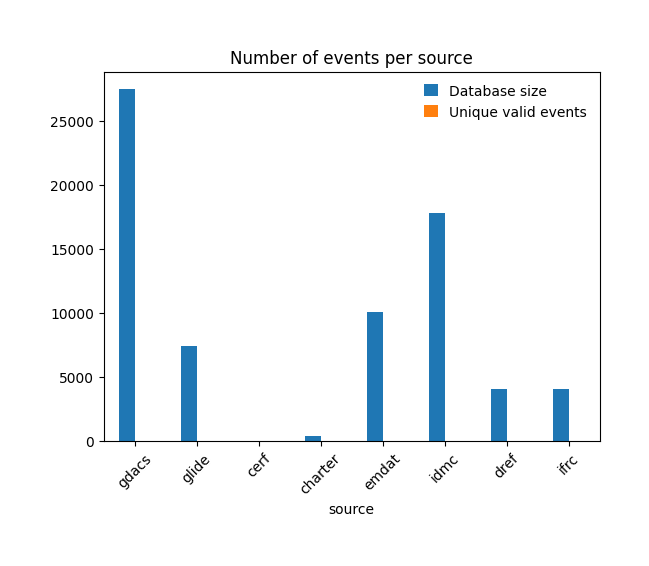

In [48]:
nb_events = []
valid_events = []

source_list = ['gdacs', 'glide', 'cerf', 'charter', 'emdat', 'idmc', 'dref', 'ifrc']
source_df_dict = {
    "gdacs": standardised_dfs["gdacs"],
    "glide": standardised_dfs["glide"],
    "cerf": standardised_dfs["cerf"],
    "charter": standardised_dfs["disaster_charter"],
    "emdat": standardised_dfs["emdat"],
    "idmc": standardised_dfs["idmc"],
    "dref": standardised_dfs["ifrc"],
    "ifrc": standardised_dfs["ifrc"],
}

for source in source_list:
    col_id = source + '_id'
    nb_events.append(source_df_dict[source].shape[0])
    valid_events.append(
        len(analysis_df.loc[(analysis_df[col_id].notna()), col_id].unique())
        if col_id in analysis_df.columns else 0
    )

count_df = pd.DataFrame()
count_df['source'] = source_list
count_df['Database size'] = nb_events
count_df['Unique valid events'] = valid_events

ax = count_df.plot.bar(x='source', rot=45)
ax.set_title('Number of events per source')


analysis 2

Text(0.5, 1.0, 'Number of events per source')

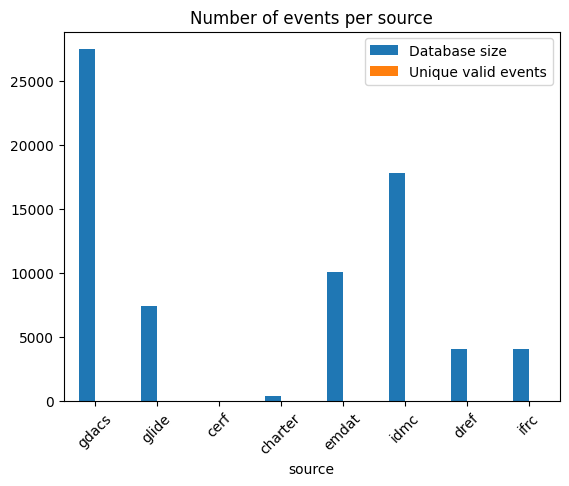

In [11]:
nb_events = []
valid_events = []

source_list = ['gdacs', 'glide', 'cerf', 'charter', 'emdat', 'idmc', 'dref', 'ifrc']
source_df_dict = {
    "gdacs": standardised_dfs["gdacs"],
    "glide": standardised_dfs["glide"],
    "cerf": standardised_dfs["cerf"],
    "charter": standardised_dfs["disaster_charter"],
    "emdat": standardised_dfs["emdat"],
    "idmc": standardised_dfs["idmc"],
    "dref": standardised_dfs["ifrc"],
    "ifrc": standardised_dfs["ifrc"],
}

for source in source_list:
    col_id = source + '_id'
    nb_events.append(source_df_dict[source].shape[0])
    valid_events.append(
        len(analysis_df.loc[(analysis_df[col_id].notna()), col_id].unique())
        if col_id in analysis_df.columns else 0
    )

count_df = pd.DataFrame()
count_df['source'] = source_list
count_df['Database size'] = nb_events
count_df['Unique valid events'] = valid_events

ax = count_df.plot.bar(x='source', rot=45)
ax.set_title('Number of events per source')


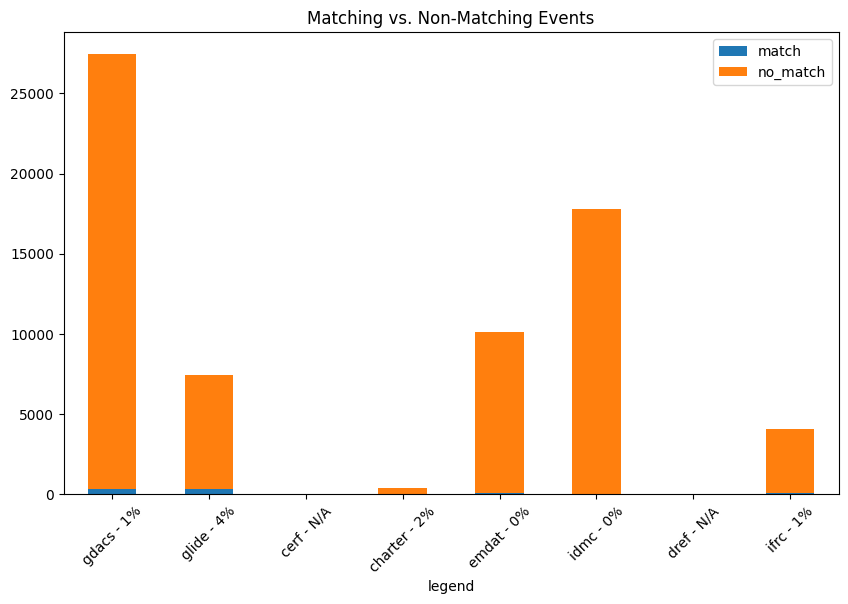

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def display_score(row):
    if pd.notna(row['score']):
        return f"{row['source']} - {int(row['score'] * 100)}%"
    else:
        return f"{row['source']} - N/A"

plot_df['legend'] = plot_df.apply(display_score, axis=1)

ax = plot_df[['legend','match','no_match']].plot.bar(
    x='legend',
    stacked=True,
    rot=45,
    figsize=(10,6)
)
ax.set_title('Matching vs. Non-Matching Events')
plt.show()


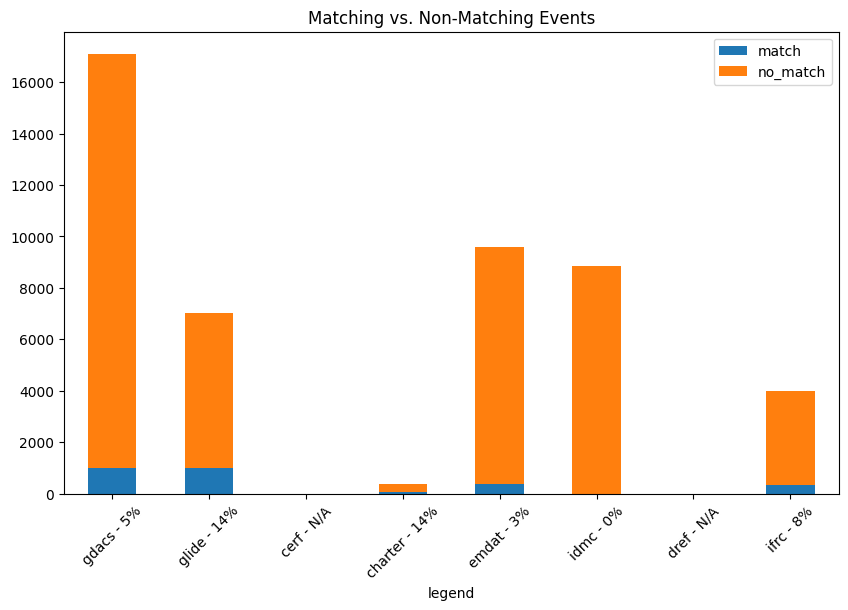

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def display_score(row):
    if pd.notna(row['score']):
        return f"{row['source']} - {int(row['score'] * 100)}%"
    else:
        return f"{row['source']} - N/A"

plot_df['legend'] = plot_df.apply(display_score, axis=1)

ax = plot_df[['legend','match','no_match']].plot.bar(
    x='legend',
    stacked=True,
    rot=45,
    figsize=(10,6)
)
ax.set_title('Matching vs. Non-Matching Events')
plt.show()


,GLIDE,EMDAT,IFRC
GDACS,324,0,0
CHARTER,0,11,3
EMDAT,0,0,69


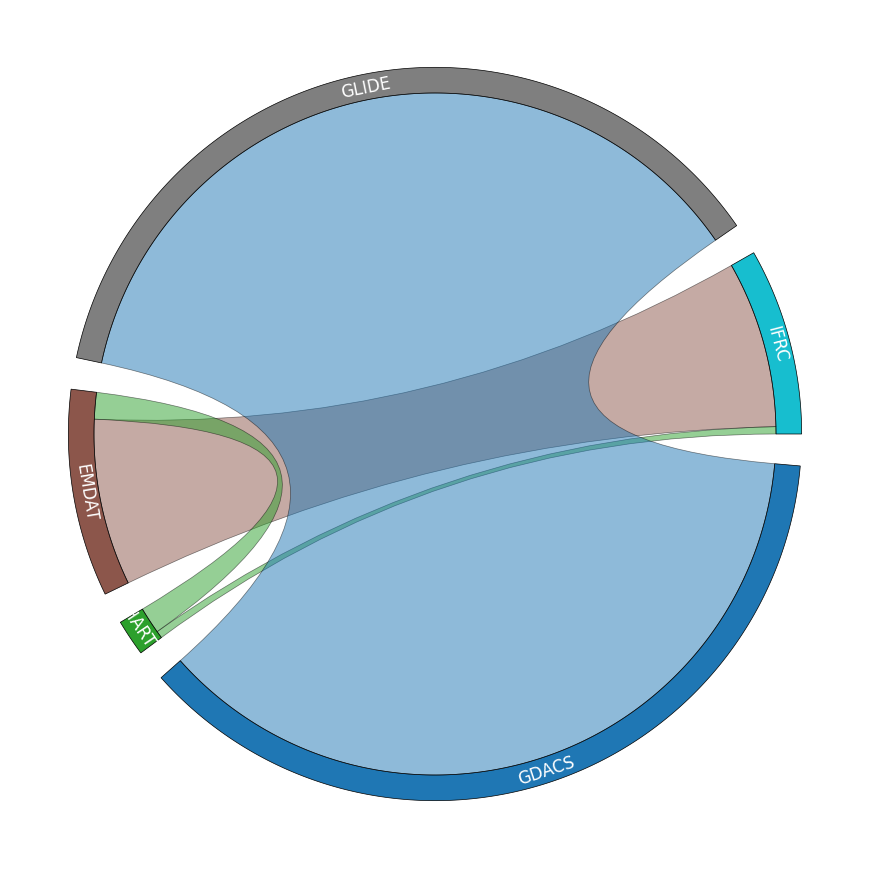

In [47]:
import pandas as pd
from pycirclize import Circos

diag_source_list = ['GDACS','GLIDE','CERF','CHARTER','EMDAT','IDMC','DREF','IFRC']
N = len(diag_source_list)
value_matrix = []

for i in range(N):
    row_vals = []
    for j in range(N):
        if i == j or i > j:
            row_vals.append(0)
        else:
            col_i = diag_source_list[i].lower()
            col_j = diag_source_list[j].lower()
            z = analysis_df[(analysis_df[col_i]) & (analysis_df[col_j])].shape[0]
            row_vals.append(z)
    value_matrix.append(row_vals)

matrix_df = pd.DataFrame(value_matrix, index=diag_source_list, columns=diag_source_list)

# Drop rows and columns that are entirely zero
non_zero_rows = matrix_df.sum(axis=1) > 0
non_zero_cols = matrix_df.sum(axis=0) > 0
matrix_df = matrix_df.loc[non_zero_rows, non_zero_cols]

display(matrix_df)

circos = Circos.initialize_from_matrix(
    matrix_df,
    start=-265,
    end=95,
    space=5,
    r_lim=(93,100),
    cmap="tab10",
    label_kws=dict(r=94, size=12, color="white"),
    link_kws=dict(ec="black", lw=0.5),
)
fig = circos.plotfig()


,GLIDE,EMDAT,IFRC
GDACS,1004,0,0
CHARTER,0,47,22
EMDAT,0,0,336
IDMC,0,0,2


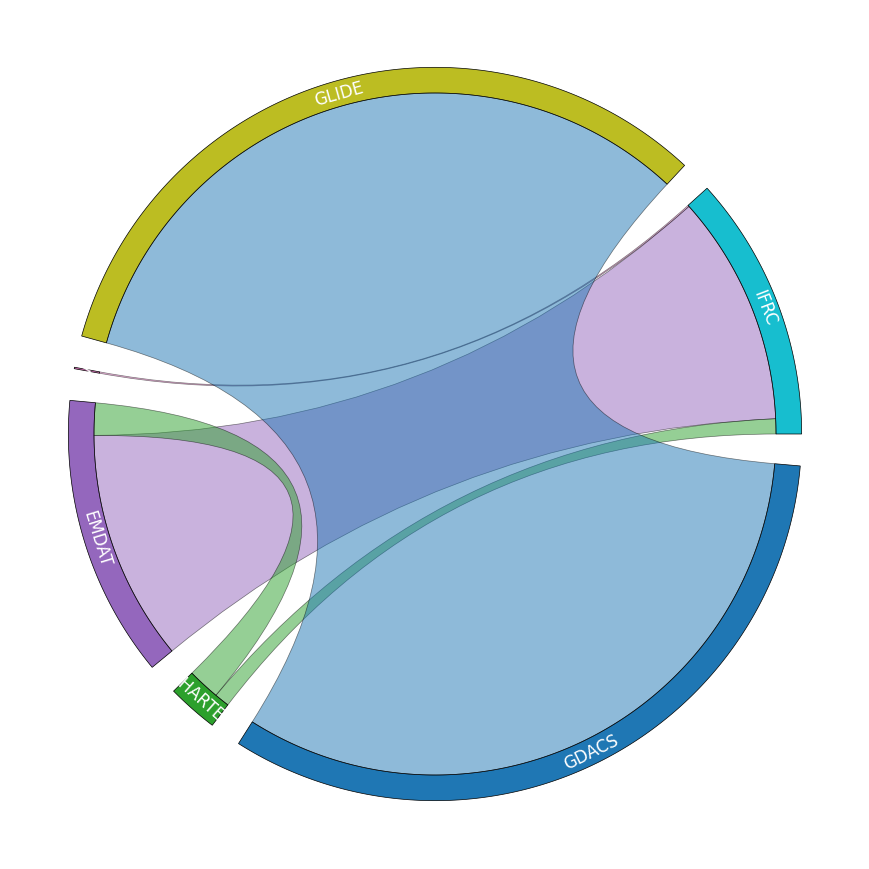

In [13]:
import pandas as pd
from pycirclize import Circos

diag_source_list = ['GDACS','GLIDE','CERF','CHARTER','EMDAT','IDMC','DREF','IFRC']
N = len(diag_source_list)
value_matrix = []

for i in range(N):
    row_vals = []
    for j in range(N):
        if i == j or i > j:
            row_vals.append(0)
        else:
            col_i = diag_source_list[i].lower()
            col_j = diag_source_list[j].lower()
            z = analysis_df[(analysis_df[col_i]) & (analysis_df[col_j])].shape[0]
            row_vals.append(z)
    value_matrix.append(row_vals)

matrix_df = pd.DataFrame(value_matrix, index=diag_source_list, columns=diag_source_list)

# Drop rows and columns that are entirely zero
non_zero_rows = matrix_df.sum(axis=1) > 0
non_zero_cols = matrix_df.sum(axis=0) > 0
matrix_df = matrix_df.loc[non_zero_rows, non_zero_cols]

display(matrix_df)

circos = Circos.initialize_from_matrix(
    matrix_df,
    start=-265,
    end=95,
    space=5,
    r_lim=(93,100),
    cmap="tab10",
    label_kws=dict(r=94, size=12, color="white"),
    link_kws=dict(ec="black", lw=0.5),
)
fig = circos.plotfig()
